In [1]:
import pickle
# Load preprocessed datasets from pickle file
with open('preprocessed_data.pkl', 'rb') as f:
    training_images, training_labels, val_images, val_labels, test_images, test_labels = pickle.load(f)


In [2]:
#Importing libraries needed for the modeling and training
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, Callback , ModelCheckpoint
from tensorflow.keras.metrics import Accuracy,binary_crossentropy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
# ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.2,
    fill_mode='nearest',
    zoom_range=0.2)

In [4]:
#Defining the base model
cancer_model = Sequential()

#First Layer
cancer_model.add(Conv2D(filters = 32, kernel_size = (3,3), input_shape = (224,224,3), activation = 'relu'))
cancer_model.add(MaxPooling2D(pool_size = (2,2)))

#Second Layer
cancer_model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'same',activation = 'relu'))
cancer_model.add(MaxPooling2D(pool_size = (2,2)))

#Third Layer
cancer_model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = 'same', activation = 'relu'))
cancer_model.add(MaxPooling2D(pool_size = (2,2)))
cancer_model.add(Dropout(0.4))

#Fourth Layer
cancer_model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = 'same', activation = 'relu'))
cancer_model.add(MaxPooling2D(pool_size = (2,2)))
cancer_model.add(Dropout(0.2))

#Flattening the layers
cancer_model.add(Flatten())

#Adding the dense layer
cancer_model.add(Dense(256, activation = 'relu'))
cancer_model.add(Dense(128, activation = 'relu'))
cancer_model.add(Dense(1, activation = 'sigmoid'))

cancer_model.summary()

C:\Users\andra\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 111, 111, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 55, 55, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 55, 55, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 27, 27, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 27, 27, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 27, 27, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 13, 13, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 13, 13, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 43264)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      11,075,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,497,281 (43.86 MB)

 Trainable params: 11,497,281 (43.86 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
#Setting the learning rate to reduce gradually over the training period
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=20*50,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

In [6]:
#Compiling the model
cancer_model.compile(loss='binary_crossentropy', optimizer=get_optimizer(), metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=10)
checkpoint = ModelCheckpoint("./Best_model/.keras", save_best_only=True)

In [7]:
#Fitted the model on the training and and validation dataset using the image augmentor for 200 epochs
history = cancer_model.fit(datagen.flow(training_images, training_labels, batch_size = 32),
                                     validation_data=datagen.flow(val_images, val_labels),
                                     epochs=200,
                                     callbacks=[early_stop,checkpoint],
                                     verbose = 1)

Epoch 1/200


C:\Users\andra\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


159/159 ━━━━━━━━━━━━━━━━━━━━ 224s 1s/step - accuracy: 0.7489 - loss: 0.5393 - val_accuracy: 0.8341 - val_loss: 0.4498
Epoch 2/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.8440 - loss: 0.4100 - val_accuracy: 0.8349 - val_loss: 0.4190
Epoch 3/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.8419 - loss: 0.4192 - val_accuracy: 0.8104 - val_loss: 0.4603
Epoch 4/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - accuracy: 0.8404 - loss: 0.4179 - val_accuracy: 0.8507 - val_loss: 0.3943
Epoch 5/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 194s 1s/step - accuracy: 0.8620 - loss: 0.3715 - val_accuracy: 0.8555 - val_loss: 0.3703
Epoch 6/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - accuracy: 0.8588 - loss: 0.3607 - val_accuracy: 0.8491 - val_loss: 0.3662
Epoch 7/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 194s 1s/step - accuracy: 0.8622 - loss: 0.3555 - val_accuracy: 0.8476 - val_loss: 0.3702
Epoch 8/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - accuracy: 0.8673 - loss: 0.3427 - val_accuracy

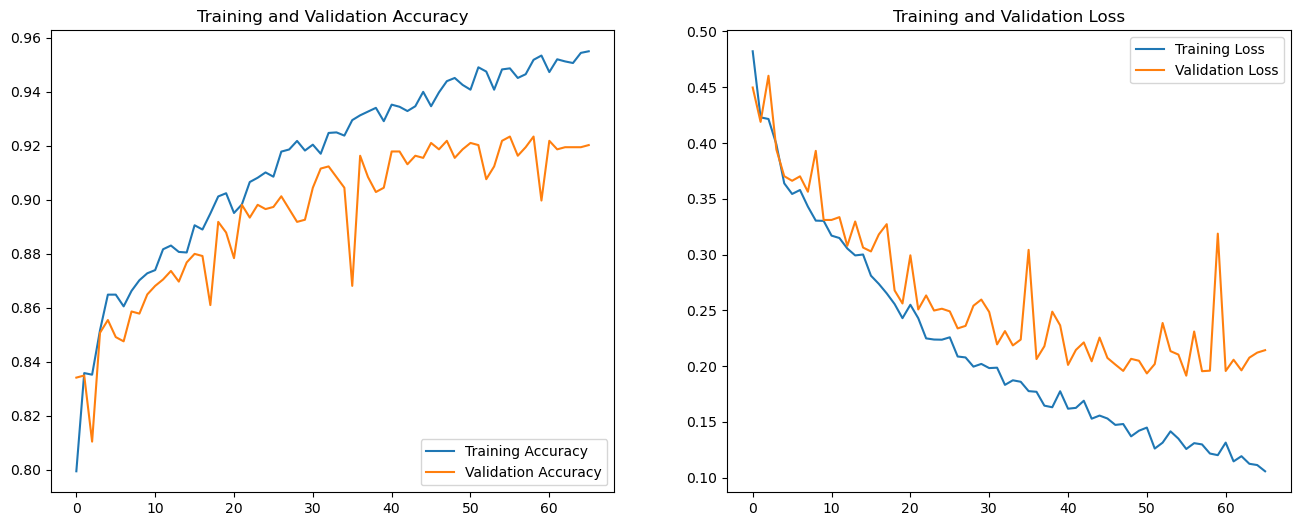

In [9]:
#Plotting the model results
import matplotlib.pyplot as plt

#Getting the accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

#Getting the losses
loss = history.history['loss']
val_loss = history.history['val_loss']

#No of epochs it trained
epochs_range = history.epoch

#Plotting Training and Validation accuracy
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

#Plotting Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [10]:
y_pred = cancer_model.predict(test_images)
print(y_pred)

50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 218ms/step
[[0.97700256]
 [1.        ]
 [0.99997365]
 ...
 [0.999973  ]
 [1.        ]
 [0.9778449 ]]


In [12]:
#Round up model prediction to 0 and 1 and convert result to an array
import numpy as np

rounded = [float(np.round(x)) for x in y_pred]
rounded_predictions = np.asarray(rounded).astype(int)
print(rounded_predictions)

[1 1 1 ... 1 1 1]


C:\Users\andra\AppData\Local\Temp\ipykernel_6208\3249192978.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rounded = [float(np.round(x)) for x in y_pred]


In [14]:
#Classification report
from sklearn.metrics import classification_report
print(classification_report(test_labels, rounded_predictions))

              precision    recall  f1-score   support

           0       0.91      0.88      0.89       482
           1       0.95      0.96      0.95      1100

    accuracy                           0.94      1582
   macro avg       0.93      0.92      0.92      1582
weighted avg       0.94      0.94      0.94      1582



In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(test_labels, rounded_predictions)
print(cm)




[[ 424   58]
 [  43 1057]]


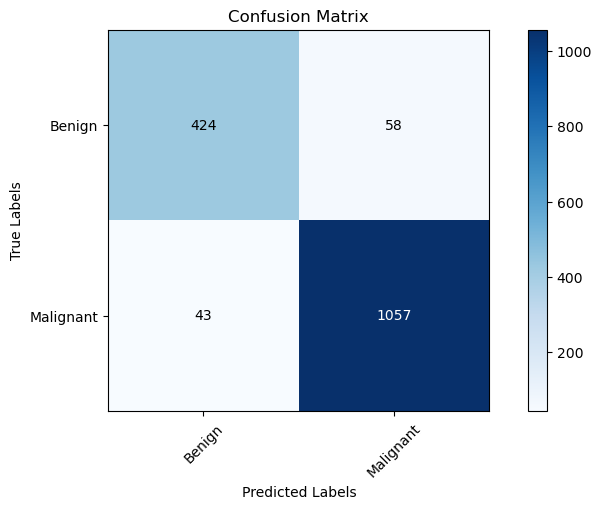

In [26]:
#Confusion matrix values
cm = np.array([[424, 58], [43, 1057]])

labels = ['Benign', 'Malignant']

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Set axis labels
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

# Add annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [28]:
#Accuracy
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(test_labels, rounded_predictions)
print('Accuracy: %f' % accuracy)

Accuracy: 0.936157


In [29]:
#Precision
from sklearn.metrics import precision_score

precision = precision_score(test_labels, rounded_predictions)
print('Precision: %f' % precision)

Precision: 0.947982


In [30]:
# Recall
from sklearn.metrics import recall_score

recall = recall_score(test_labels, rounded_predictions, pos_label=1)
print('Recall: %f' % recall)

Recall: 0.960909


In [32]:
#Specificity
specificity = recall_score(test_labels, rounded_predictions, pos_label=0)
print('Specificity: %f' % specificity)

Specificity: 0.879668


In [33]:
#F1-score
from sklearn.metrics import f1_score

F1_score = f1_score(test_labels, rounded_predictions)
print('F1_score: %f' % F1_score)

F1_score: 0.954402


In [36]:
#Save the model
cancer_model.save("CNN_Model.h5")
